In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:

import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

# Setting styles
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="whitegrid", color_codes=True, rc={"figure.figsize": (12.7, 9.27)})

random_state = 123


In [2]:

df = pd.read_csv(os.path.join("data", "processed", "train.csv"))
df = df.drop(columns=["train"])

df_valid = pd.read_csv(os.path.join("data", "processed", "test.csv"))
df_valid = df_valid.drop(columns=["train"])


In [3]:

X = df.drop(columns=["longitude", "latitude", "floor"])
y_lon = df.longitude
y_lat = df.latitude
y_floor = df.floor
y = pd.DataFrame({"lon": y_lon, "lat": y_lat, "floor": y_floor})

X_valid = df_valid.drop(columns=["longitude", "latitude", "floor"])
y_valid_lon = df_valid.longitude
y_valid_lat = df_valid.latitude
y_valid_floor = df_valid.floor
y_valid = pd.DataFrame({"lon": y_valid_lon, "lat": y_valid_lat, "floor": y_valid_floor})


In [4]:

X_train, X_test, y_train_lon, y_test_lon = train_test_split(
    X,
    y_lon,
    test_size=0.2,
    random_state=random_state,
    stratify=df[["buildingid", "floor"]],
)

_, _, y_train_lat, y_test_lat = train_test_split(
    X,
    y_lat,
    test_size=0.2,
    random_state=random_state,
    stratify=df[["buildingid", "floor"]],
)

_, _, y_train_floor, y_test_floor = train_test_split(
    X,
    y_floor,
    test_size=0.2,
    random_state=random_state,
    stratify=df[["buildingid", "floor"]],
)

y_train = pd.DataFrame({"lon": y_train_lon, "lat": y_train_lat, "floor": y_train_floor})

y_test = pd.DataFrame({"lon": y_test_lon, "lat": y_test_lat, "floor": y_test_floor})


In [5]:


def calculate_distance(y, y_pred):
    pred_lon = y_pred[:, 0]
    pred_lat = y_pred[:, 1]
    pred_floor = y_pred[:, 2]

    lon_diff2 = (pred_lon - y.lon) ** 2
    lat_diff2 = (pred_lat - y.lat) ** 2
    # lets assume that the height of the floors is 5 meters
    floor_diff2 = ((pred_floor - y.floor) * 5) ** 2

    distance_squared = lon_diff2 + lat_diff2 + floor_diff2

    mean_distance = distance_squared.apply(lambda x: x ** (1 / 2)).mean()

    return mean_distance


distance_scorer = make_scorer(calculate_distance, greater_is_better=False)



In [6]:

knn_model_no_scaling = Pipeline([("knn", KNeighborsRegressor())])
knn_model_standard_scaler = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsRegressor())]
)
knn_model_robust_scaler = Pipeline(
    [("scaler", RobustScaler()), ("knn", KNeighborsRegressor())]
)


In [7]:

# models = [knn_model_no_scaling, knn_model_standard_scaler, knn_model_robust_scaler]

# model_names = ["no_scaling", "standard_scaler", "robust_scaler"]

# param_grid = {
#     "knn__n_neighbors": [1, 2, 3],
#     "knn__weights": ["uniform", "distance"],
#     "knn__p": [1, 2],
# }

# results = {}
# for name, model in zip(model_names, models):
#     param_search = GridSearchCV(
#         model, param_grid, scoring=distance_scorer, n_jobs=-2, cv=8, verbose=2
#     )

#     param_search.fit(X_train, y_train)
#     print(name)
#     print("Best Params:")
#     print(param_search.best_params_)
#     print("Best CV Score:")
#     print(-param_search.best_score_)

# no_scaling
# Best Params:
# {'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}
# Best CV Score:
# 2.3362376640738565

# standard_scaler
# Best Params:
# {'knn__n_neighbors': 2, 'knn__p': 1, 'knn__weights': 'distance'}
# Best CV Score:
# 2.577258493818289

# robust_scaler
# Best Params:
# {'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}
# Best CV Score:
# 2.3362376640738565


In [8]:

knn_model = KNeighborsRegressor(n_neighbors=1, p=1, weights="uniform")
knn_model.fit(X, y)

pred = knn_model.predict(X_valid)

score = calculate_distance(y_valid, pred)

pred_lon = pred[:, 0]
pred_lat = pred[:, 1]
pred_floor = pred[:, 2]

lon_diff2 = (pred_lon - y_valid_lon) ** 2
lat_diff2 = (pred_lat - y_valid_lat) ** 2
# lets assume that the height of the floors is 5 meters
floor_diff2 = ((pred_floor - y_valid_floor) * 5) ** 2

distance_squared = lon_diff2 + lat_diff2 + floor_diff2

distance = distance_squared.apply(lambda x: x ** (1 / 2))

predictions = pd.DataFrame(
    {
        "LATITUDE": pred_lat,
        "LONGITUDE": pred_lon,
        "FLOOR": pred_floor,
        "distance": distance,
    }
)

true_values = pd.DataFrame(
    {
        "LATITUDE": y_valid_lat,
        "LONGITUDE": y_valid_lon,
        "FLOOR": y_valid_floor,
        "distance": distance,
    }
)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=1, p=1,
                    weights='uniform')

Mean error in meters 10.12292065466903


Text(0.5, 1.0, 'Predictions Floor 0')

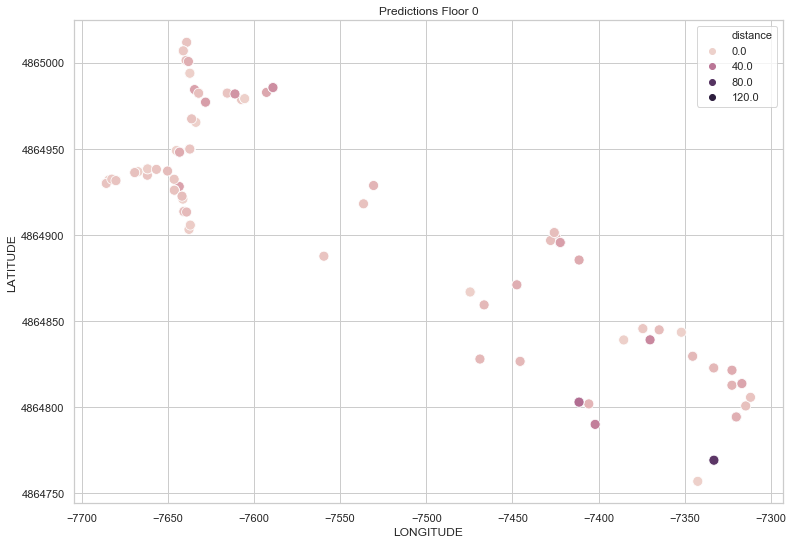

Text(0.5, 1.0, 'Real Values Floor 0')

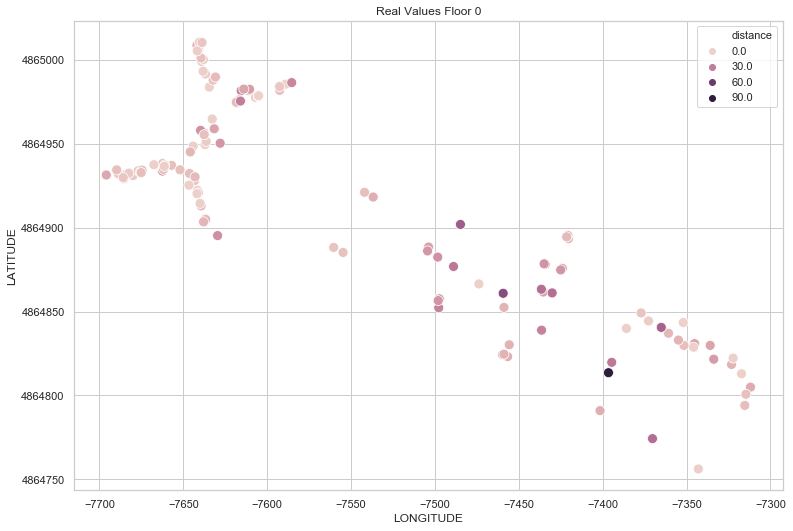

Text(0.5, 1.0, 'Predictions Floor 1')

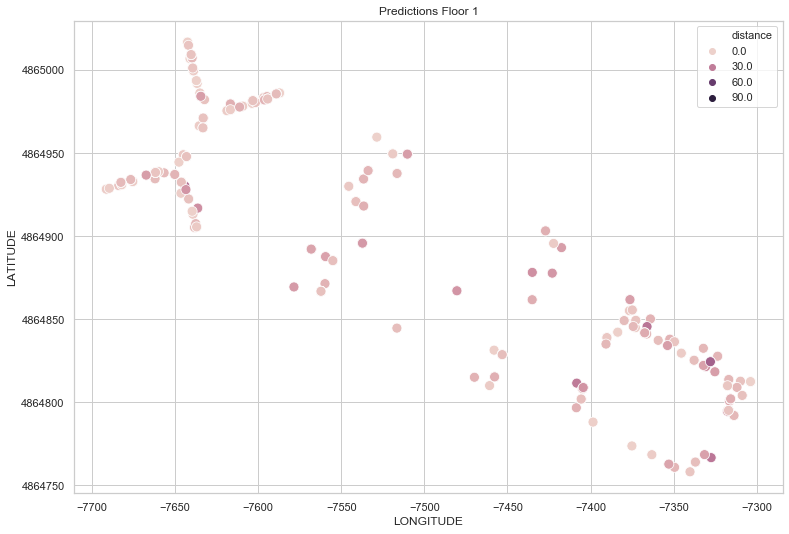

Text(0.5, 1.0, 'Real Values Floor 1')

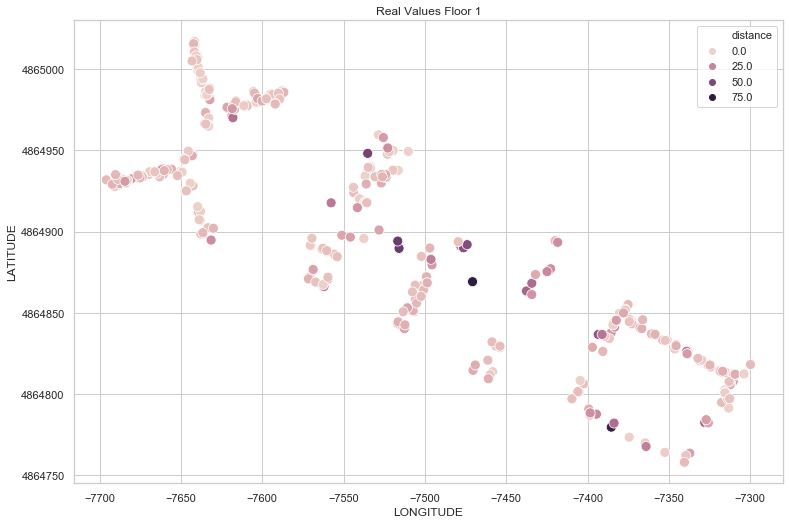

Text(0.5, 1.0, 'Predictions Floor 2')

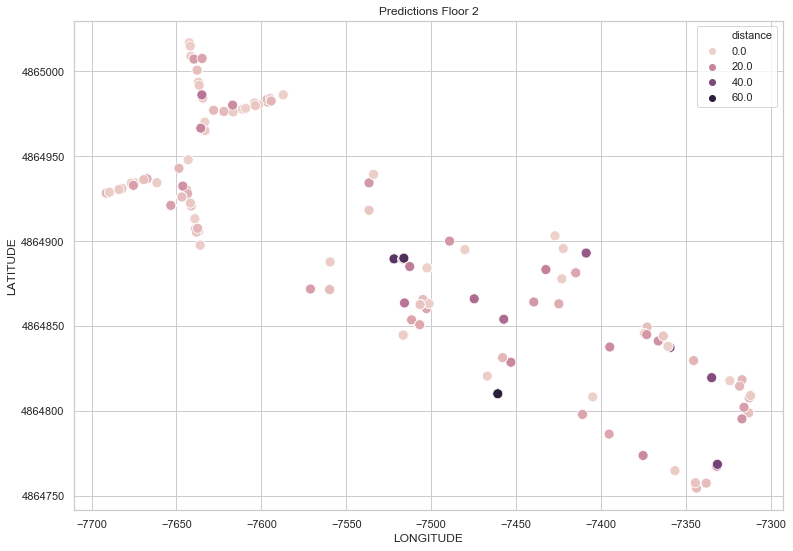

Text(0.5, 1.0, 'Real Values Floor 2')

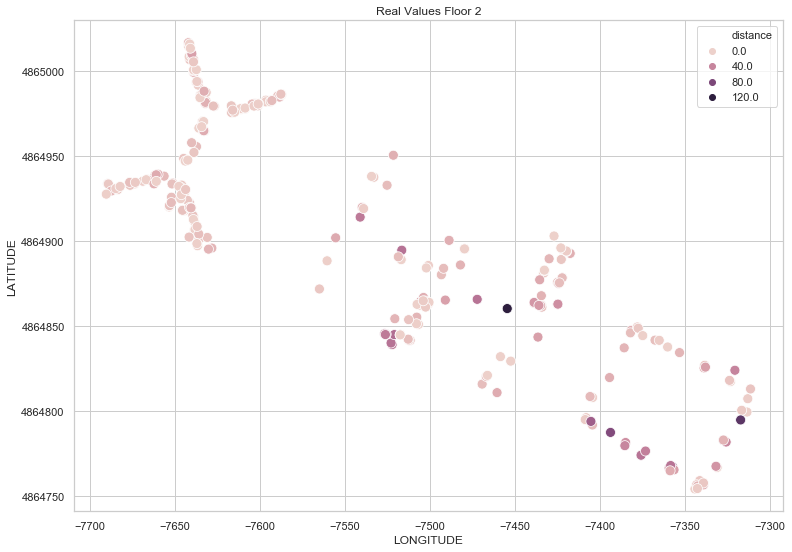

Text(0.5, 1.0, 'Predictions Floor 3')

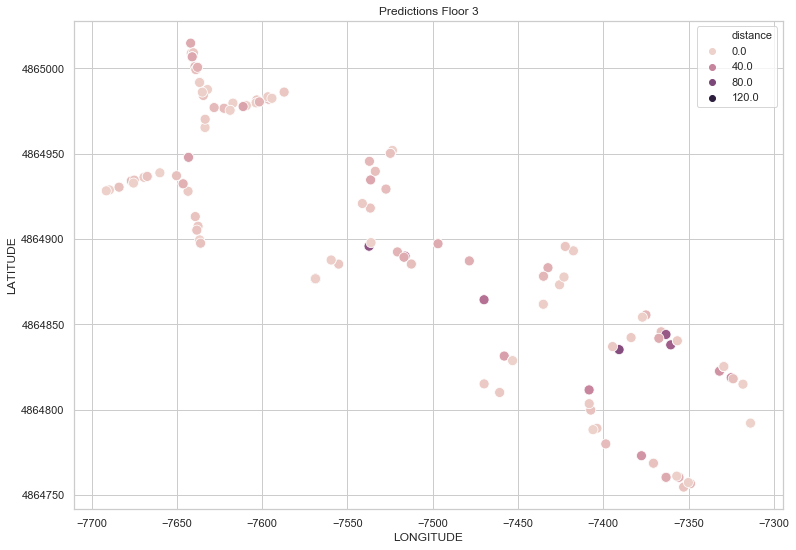

Text(0.5, 1.0, 'Real Values Floor 3')

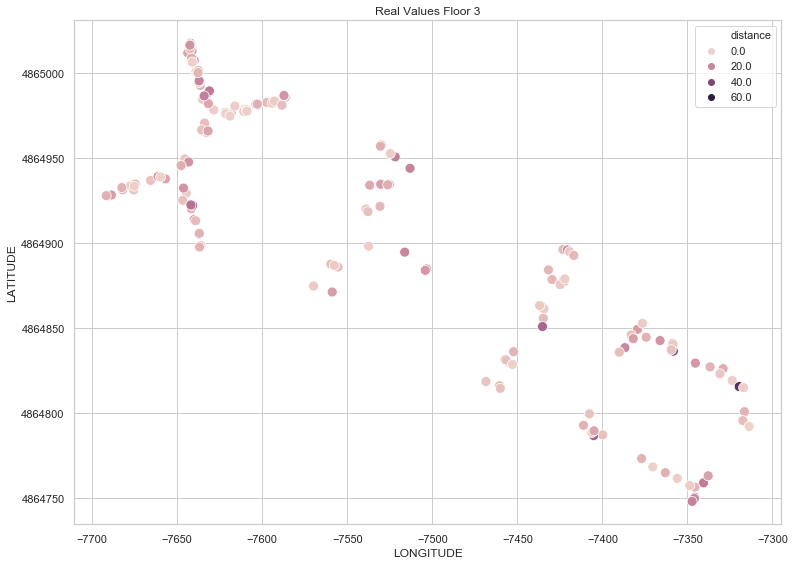

Text(0.5, 1.0, 'Predictions Floor 4')

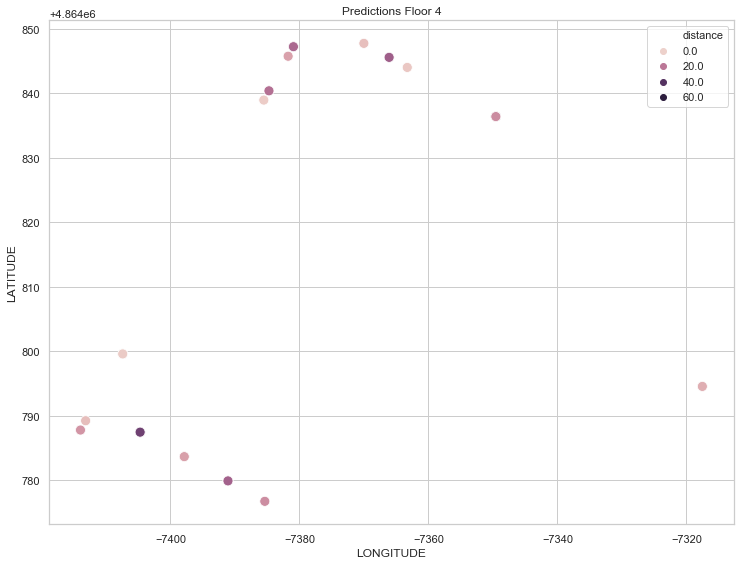

Text(0.5, 1.0, 'Real Values Floor 4')

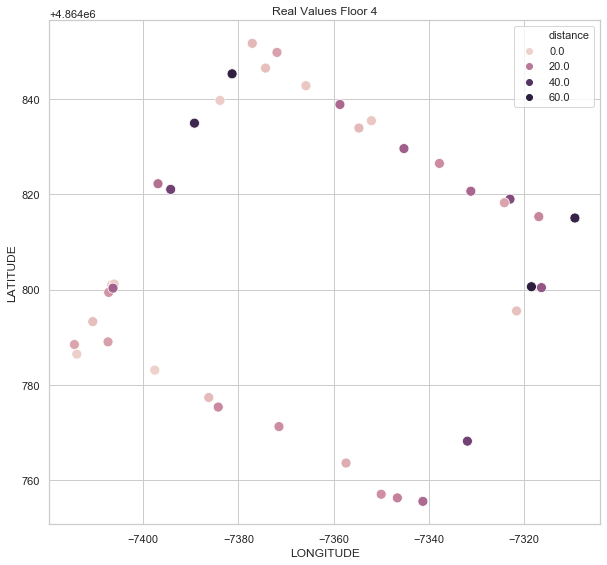

In [9]:

print(f"Mean error in meters {score}")

for floor in sorted(predictions.FLOOR.unique()):
    fig, ax = plt.subplots()
    sns.scatterplot(
        x="LONGITUDE",
        y="LATITUDE",
        hue="distance",
        ax=ax,
        s=100,
        data=predictions[predictions["FLOOR"] == int(floor)],
    )
    ax.set_aspect(aspect="equal")
    plt.title(f"Predictions Floor {int(floor)}")
    plt.show()

    fig, ax = plt.subplots()
    sns.scatterplot(
        x="LONGITUDE",
        y="LATITUDE",
        hue="distance",
        s=100,
        data=true_values[true_values["FLOOR"] == int(floor)],
        ax=ax,
    )
    ax.set_aspect(aspect="equal")
    plt.title(f"Real Values Floor {int(floor)}")
    plt.show()



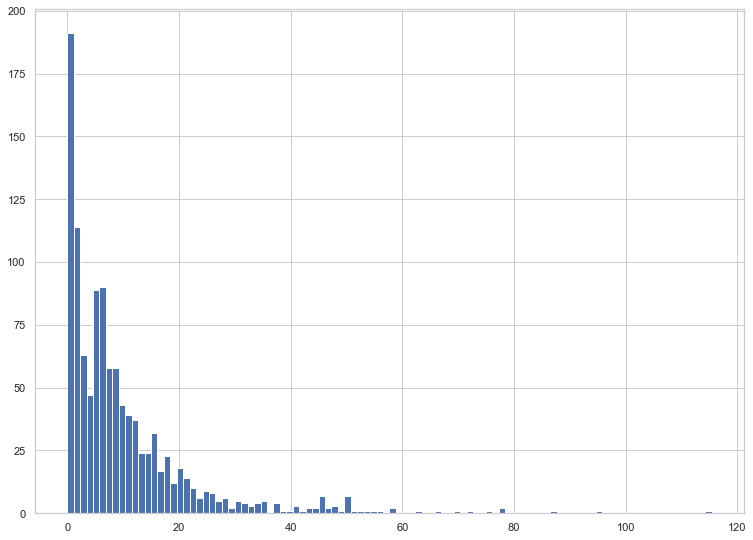

In [10]:

predictions.distance.hist(bins=100)
